In [245]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt


from minepy import MINE
import dcor

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import random

# Univariate Feature Analysis

Compute feature central statistics, missing values percentage & outlier detection.

Explore feature distributions. Density distributions for continuous variables and frequency ranking for categorical variables.


### Dataset description

In [121]:
t=sns.load_dataset('titanic')
t = t.astype({"pclass": 'object','survived':'object','parch':'object'})
t.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


**Central stats - continuous features**

In [122]:
t.describe()

,age,sibsp,fare
count,714.000000,891.000000,891.000000
mean,29.699118,0.523008,32.204208
std,14.526497,1.102743,49.693429
min,0.420000,0.000000,0.000000
25%,20.125000,0.000000,7.910400
50%,28.000000,0.000000,14.454200
75%,38.000000,1.000000,31.000000
max,80.000000,8.000000,512.329200


**Central stats - categorical features**

In [123]:
t.describe(include=['O'])

,survived,pclass,sex,parch,embarked,who,embark_town,alive
count,891,891,891,891,889,891,889,891
unique,2,3,2,7,3,3,3,2
top,0,3,male,0,S,man,Southampton,no
freq,549,491,577,678,644,537,644,549


**Missing values percentage per feature**

In [136]:
# the missing value token depends on context and dataset particularities
percent_missing = t.isnull().sum() * 100 / len(t)
missing_values = pd.DataFrame({'column_name': t.columns,
                                 'percent_missing': percent_missing}).reset_index(drop=True)
missing_values.sort_values('percent_missing', inplace=True, ascending=False)
missing_values

,column_name,percent_missing
11,deck,77.216611
3,age,19.865320
7,embarked,0.224467
12,embark_town,0.224467
0,survived,0.000000
1,pclass,0.000000
2,sex,0.000000
4,sibsp,0.000000
5,parch,0.000000
6,fare,0.000000


**Missing values counts per data instance**

In [271]:
row_nulls = pd.DataFrame(t.apply(lambda x: len(x) - x.count(), axis=1)).rename({0:'miss_val_count'}).sort_values(by = 'miss_val_count', ascending = False)
row_nulls.head()

KeyError: 'miss_val_count'

**Outlier detection (IQR method) - continuous features**

In [154]:
tnum = t.select_dtypes(include=np.number)
q1 = tnum.quantile(0.25)
q3 = tnum.quantile(0.75)
iqr = q3 - q1

outliers = pd.DataFrame((tnum < (q1 - 1.5 * iqr)) | (tnum > (q3 + 1.5 * iqr)))

outliers_fare = pd.DataFrame(tnum.fare[outliers.fare])
outliers_fare.head()

,fare
1,71.2833
27,263.0000
31,146.5208
34,82.1708
52,76.7292


### Feature univariate distributions

**Continuous features**

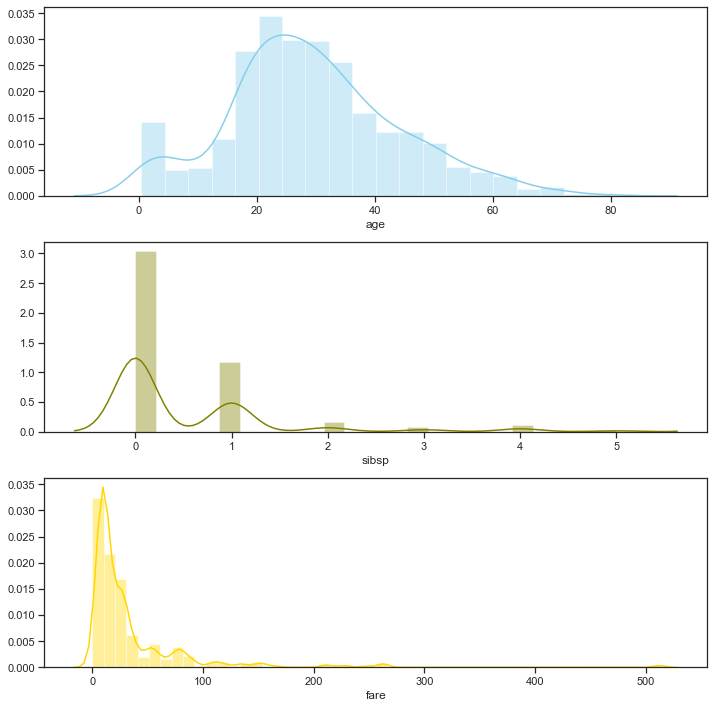

In [191]:
f, axes = plt.subplots(3, figsize=(10, 10))
variables = ['age','sibsp','fare']
colors = ['skyblue','olive','gold']
tnum_nona = tnum.dropna()

for var,axis,color in zip(variables,axes,colors):
    sns.distplot(tnum_nona[var] , color=color, ax=axis)
    
plt.tight_layout()

**Categorical features**

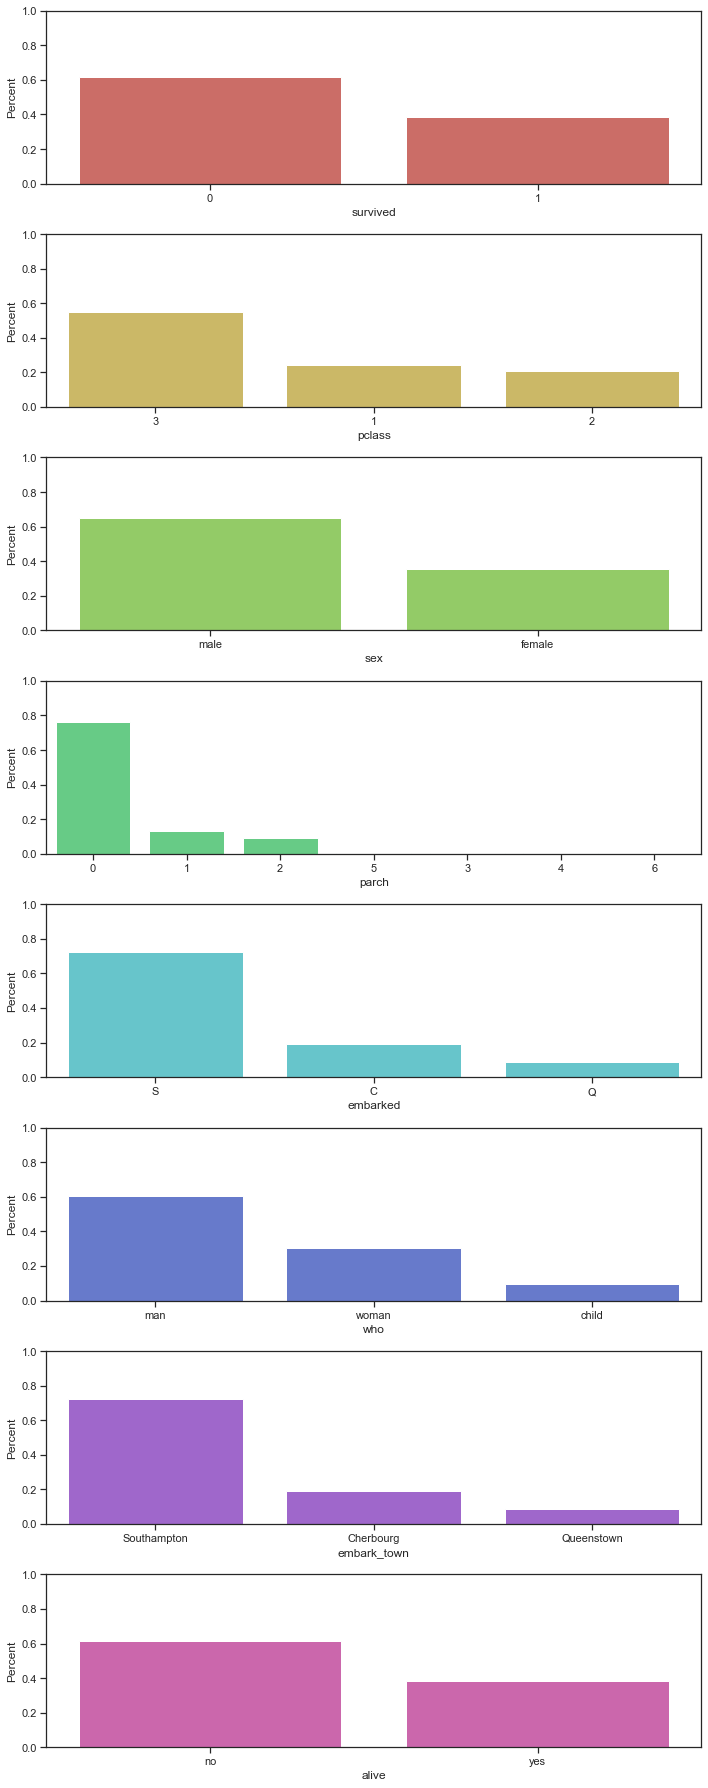

In [223]:
tobj = t.select_dtypes(include=object)
variables = list(tobj.columns.values)
colors = sns.color_palette("hls", len(variables))

f, axes = plt.subplots(len(variables), figsize=(10, 25))
    
for var,axis,color in zip(variables,axes,colors):
    cv = pd.DataFrame(tobj[var].value_counts(normalize=True)).reset_index()
    sns.barplot(x='index', y = var, data = cv, color=color, ax=axis, order = cv['index'])
    axis.set(ylabel="Percent")
    axis.set(xlabel=var)
    axis.set_ylim(0, 1)
    
plt.tight_layout()


# Pair-wise relationship Analysis

Pair-wise relationship analysis objective is to understand non-trivial feature relationships (linear or nonlinear) between input features and also between them and the response variable. 

Bivariate plotting and statistical tests are used.

The nature of pairing between variables and/or response: continuous-continuous, categorical-categorical, continuous-categorical; affects which statistic test to apply. Non-parametric tests have been selected so to avoid strong assumptions (such as linearity of the relation). 

Do not use Pearson Correlation, if other options can be used.

##  Visualization


### Matrix plot

For classification tasks use response variable as hue

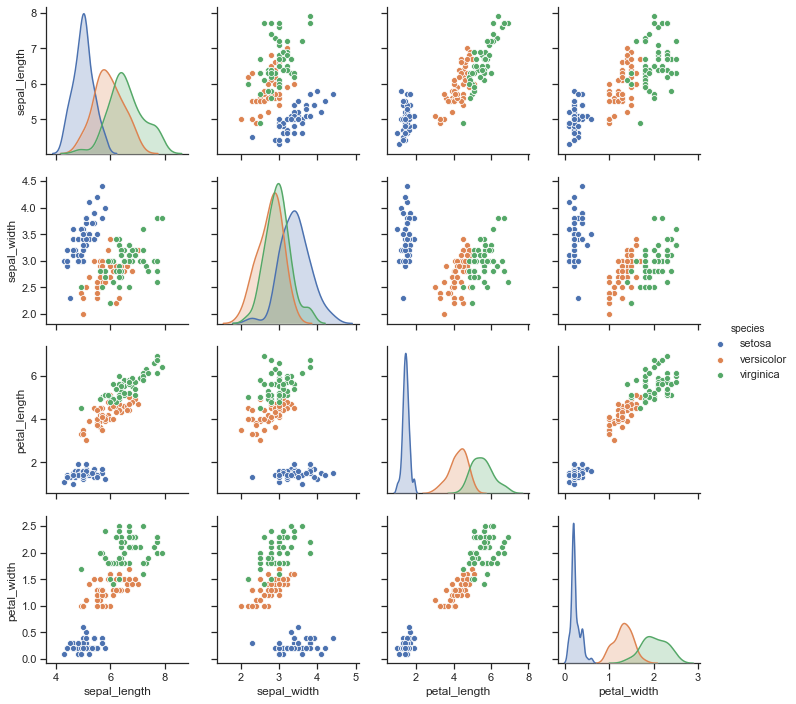

In [73]:
import seaborn as sns
sns.set(style="ticks")

df = sns.load_dataset("iris")
sns.pairplot(df, hue="species")

**Another example (less noiser):**

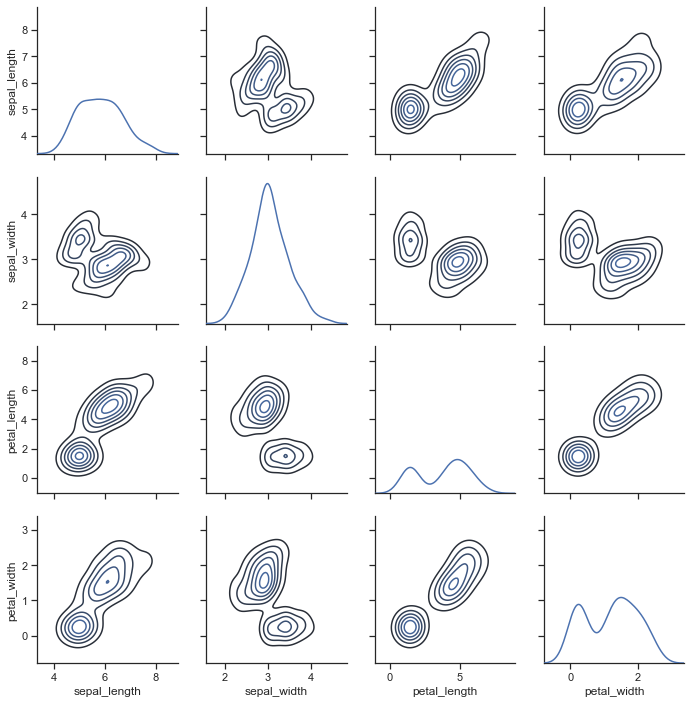

In [76]:
iris = sns.load_dataset("iris")
g = sns.PairGrid(iris)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

### Continuous feature vs binary response variable (classification)

response variable := "species"

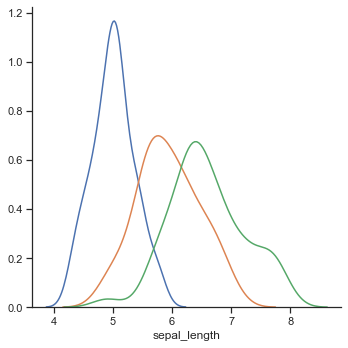

In [79]:
df = sns.load_dataset("iris")

g = sns.FacetGrid(df,hue='species',height=5)
g.map(sns.kdeplot, 'sepal_length')

### Continuous feature vs categorical feature

continuous: total_bill

categorical: day of week

response variable (classification): smoker 

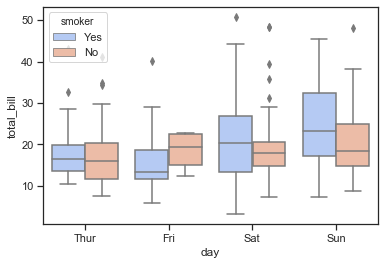

In [80]:
t=sns.load_dataset('tips')
sns.boxplot(x="day",y="total_bill",hue="smoker",data=t, palette="coolwarm")

## Statistical tests

### Measuring strength of the relationship between two continuous (or discrete) variables

#### Maximal Information coefficient

*Theory*

https://en.wikipedia.org/wiki/Maximal_information_coefficient

*package documentation*

https://pypi.org/project/minepy/


In [6]:
m = MINE()
x = np.random.uniform(-1, 1, 10000)
m.compute_score(x, x**2)
print(m.mic())

1.0000000000000009


In [7]:
m = MINE()
np.random.seed(0)
size = 300
x = np.random.normal(0, 1, size)
m.compute_score(x, x + np.random.normal(0, 1, size))
print("Lower noise",m.mic()) 
                                     
m.compute_score(x, x + np.random.normal(0, 10, size))
print("Higher noise",m.mic())

y1 = np.random.uniform(-1, 1, 10000)
y2 = np.random.uniform(-1, 1, 10000)
m.compute_score(y1,y2)
print("Zero relation",m.mic())

Lower noise 0.47800990587829684
Higher noise 0.18188333765434603
Zero relation 0.06068134747981231


#### Distance correlation

*Theory*

https://en.wikipedia.org/wiki/Distance_correlation

*package documentation*

https://dcor.readthedocs.io/en/latest/?badge=latest

In [11]:
x = np.random.uniform(-1, 1, 100000)
dcor.distance_correlation(x, x**2)

0.4911034088073455

### Measuring strength of the relationship between two categorical variables

#### Cramer's V

*Theory*

https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

https://pythonfordatascience.org/chi-square-test-of-independence-python/

*documentation*

https://stackoverflow.com/questions/20892799/using-pandas-calculate-cramérs-coefficient-matrix



In [63]:
def cramers_corrected_stat(confusion_matrix):
    """ Cramers V statistic uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [66]:
np.random.seed(123)

df = pd.DataFrame(np.random.randint(3, size= (101, 3)),
                  columns= ['disease', 'severity', 'alive'])

In [67]:
df.head()

,disease,severity,alive
0,2,1,2
1,2,0,2
2,2,1,2
3,1,2,1
4,0,1,2


In [69]:
confusion_matrix = pd.crosstab(df['disease'], df['alive'])
confusion_matrix

severity,0,1,2
disease,,,
0,13,11,6
1,13,9,9
2,14,13,13


In [70]:
cramers_corrected_stat(confusion_matrix)

0.08978596534880241

### Measuring strength of the relationship between a continuous and a categorical variables

#### Kruskal-Wallis H test

*Theory*

https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance

*documentation*

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html

In [71]:
ss.kruskal([13.1,23.28,4.7,6.1],["A","A","B","C"])


KruskalResult(statistic=5.397590361445778, pvalue=0.020164573022335715)

# Feature importance - models perspective


Last step of a Exploratory Data Analysis is to gather insights regarding how important features are taking into account the model perspective.

Mostly all scikit models have a sort of implementation to check for feature importance provided that they do have an attribute like coef_ (linear models + SVM), feature_importances_ (Tree based).

_At this stage (ExpDA) **we do not need to check Feature selection for each specific model in the model championship**. We can work with a broad perspective and separate models into LINEAR/NONLINEAR and the nature of the task._

For a **Regression** task we should use:
* LINEAR:
    * L2(Ridge) regularization Recursive Feature Elimination (RFE) combined with an stability analysis. _Note: Remember - input variables should be scaled (normalized)._
* NONLINEAR:
    * RFE with RandomForestRegressor feature importance

For a **Classification** task we should use:
* LINEAR:
    * Logistic regression (modifiy penalty parameter - l2) RFE combined with stability analysis. _Note: Remember - input variables should be scaled (normalized)._
* NONLINEAR:
    * RFE with RandomForestClassifier feature importance.

**Stability Analysis (linear models)**

The objective of Stability analysis for Linear models is to account for statistical noisy variations. RandomizedLasso and RandomizedLogistic are deprecated in newer version of scikit-learn, so this should be implemented manually. The logic in these cases is the following:

for r in random seeds (random_state):
    
    StratifiedKFold => because RFE is a deterministic method thw way to statistically perturb the results is by randomly sampling different folds of data
    RFE => Logistic or Ridge model (depending on task)
    # for each iteration of the random loop save selector.ranking_ (together with the corresponding feature names)
    # recursively construct a DataFrame where <col: feature name, row: r> the element is the corresponding selector.ranking_ score.

Things to check in the scoring DataFrame:
* Take column mean and sort it in ascending order. The order gives the importance of each feature for the Linear model used.
* If some features mean is equal (exact) to one, this is telling you that is a very important feature that was always selected by the RFE method.
* If feature means are pretty similar OR there is a lot of noise in the DataFrame (selected features have strong positional variations) this means that there is a lot of variation in the model coefficient and the model is not a good choice. Three options in place, either:  
    * Change the model (maybe a regularization change would suffice) 
    * Manually modify hyperparameters.
    * Multi-colinearity is impacting your model heavily. So you will have to use insights from pair-wise relationship analysis to remove highly correlated variables. 

## Stability analysis for LogisticRegression

In [265]:
# load the iris datasets. No need to scale this toy dataset 
# For the sake of the example we won't separate in ExpDA, Train & Test (!!!) <= 

# OFC this has to be run in parallel & optimize, is just the concept explained (!)

dataset = datasets.load_breast_cancer()
names = dataset["feature_names"]

scores = []
for n in range(10,1010,10):
    estimator = LogisticRegression(penalty = 'l2', random_state = n, solver = 'liblinear')
    # shuffle data because of RFE deterministic nature
    skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = n)
    train_index, _ = random.choice(list(skf.split(dataset.data, dataset.target)))
    #rank all features, i.e continue the elimination until the last one
    rfe = RFE(estimator, n_features_to_select=1)
    rfe = rfe.fit(dataset.data[train_index], dataset.target[train_index])
    # summarize the selection of the attributes
    scores.append(dict(zip(names, map(lambda x: round(x, 4), rfe.ranking_))))

scores = pd.DataFrame(scores)
scores.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,100.000000,100.000000,100.00000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000
mean,4.220000,13.750000,19.03000,29.070000,16.77000,19.570000,2.250000,6.150000,11.270000,21.290000,...,4.090000,13.040000,9.940000,24.200000,18.030000,11.700000,1.0,4.820000,17.760000,15.800000
std,0.732782,3.674578,5.60385,1.007597,2.97075,2.499515,0.701729,1.157976,3.475324,5.191864,...,3.573457,2.019701,3.386903,1.763834,3.597011,3.815174,0.0,0.903193,5.075431,3.041796
min,3.000000,9.000000,7.00000,26.000000,8.00000,12.000000,2.000000,4.000000,5.000000,8.000000,...,2.000000,10.000000,6.000000,19.000000,9.000000,4.000000,1.0,2.000000,5.000000,8.000000
25%,4.000000,12.750000,16.00000,29.000000,16.00000,18.000000,2.000000,6.000000,7.000000,16.000000,...,3.000000,12.000000,8.000000,23.000000,17.000000,9.000000,1.0,5.000000,15.000000,15.000000
50%,4.000000,14.000000,18.00000,29.000000,17.00000,20.000000,2.000000,6.000000,12.000000,24.000000,...,3.000000,13.000000,9.000000,24.000000,19.000000,10.000000,1.0,5.000000,19.000000,16.000000
75%,4.000000,14.000000,23.25000,30.000000,19.00000,21.000000,2.000000,6.000000,14.000000,25.250000,...,3.000000,13.000000,10.000000,26.000000,20.000000,14.000000,1.0,5.000000,21.000000,18.000000
max,7.000000,29.000000,30.00000,30.000000,23.00000,24.000000,6.000000,14.000000,18.000000,29.000000,...,22.000000,21.000000,20.000000,27.000000,26.000000,22.000000,1.0,6.000000,24.000000,22.000000
